# Introduction

The purpose of this notebook is to download data and process it. As a result we will get a dataset ready for further analyses and modeling.

In [1]:
import matplotlib
import matplotlib.pyplot as plt

# let matplotlib plots be part of Jupyter Notebook
%matplotlib inline

# set up higher resolution for matplotlib plots
%config InlineBackend.figure_format = 'retina'

# Data loading and processing pipeline

In [2]:
# Change folder to sub-project root
%cd ..

/Users/mariuszrokita/GitHub/wroclawski-rower-miejski/bikerentals


In [3]:
# execute tests to make sure everything is working as expected
!python -m pytest

============================= test session starts ==============================
platform darwin -- Python 3.6.8, pytest-5.2.2, py-1.8.0, pluggy-0.13.0
rootdir: /Users/mariuszrokita/GitHub/wroclawski-rower-miejski, inifile: tox.ini
collected 24 items                                                             

src/tests/cleaning/test_extract_gps_from_station_name.py ..              [  8%]
src/tests/cleaning/test_pipeline.py ....                                 [ 25%]
src/tests/cleaning/test_remove_missing_gps.py ..                         [ 33%]
src/tests/cleaning/test_remove_same_location.py ...                      [ 45%]
src/tests/features/test_day_of_week.py ..                                [ 54%]
src/tests/features/test_distance.py ..                                   [ 62%]
src/tests/features/test_holidays.py ...                                  [ 75%]
src/tests/features/test_hour.py ..                                       [ 83%]
src/tests/features/test_month.py ..            

In [4]:
# Go to source folder
%cd src

/Users/mariuszrokita/GitHub/wroclawski-rower-miejski/bikerentals/src


In [5]:
# run data loading and processing pipeline 
# (with soft deleting so that we can inspect everything)
%run -t run_pipeline.py --hard-delete=False

Pipeline execution started
Root folder set to: /Users/mariuszrokita/GitHub/wroclawski-rower-miejski/bikerentals
* GpsFromStationNameExtractor *
--> input data shape:  (464199, 10)
--> output data shape:  (464199, 10)
* GpsFromStationNameExtractor *
--> input data shape:  (464199, 10)
--> output data shape:  (464199, 10)
* SameLocationRemover *
--> input data shape:  (464199, 10)
--> output data shape:  (464199, 11)
* MissingGpsLocationRemover *
--> input data shape:  (464199, 11)
--> output data shape:  (464199, 11)
* SeasonFeature *
--> input data shape:  (464199, 11)
--> output data shape:  (464199, 12)
* HolidaysFeature *
--> input data shape:  (464199, 12)
--> output data shape:  (464199, 13)
* DayOfWeekFeature *
--> input data shape:  (464199, 13)
--> output data shape:  (464199, 14)
* HourFeature *
--> input data shape:  (464199, 14)
--> output data shape:  (464199, 15)
* MonthFeature *
--> input data shape:  (464199, 15)
--> output data shape:  (464199, 16)
* DistanceFeature *
-

# Post-processing inspection

In [6]:
import os
import pandas as pd

filepath = os.path.join(os.getcwd(), '..', 'data', 'processed', 'bike_rentals.csv')

In [7]:
# load csv and set proper column types
bike_rentals_df = pd.read_csv(filepath)
bike_rentals_df['Rental datetime'] = pd.to_datetime(bike_rentals_df['Rental datetime'])
bike_rentals_df['Return datetime'] = pd.to_datetime(bike_rentals_df['Return datetime'])
bike_rentals_df['Duration'] = pd.to_timedelta(bike_rentals_df['Duration'])

In [8]:
bike_rentals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464199 entries, 0 to 464198
Data columns (total 17 columns):
Bike number                 464199 non-null int64
Rental datetime             464199 non-null datetime64[ns]
Return datetime             464199 non-null datetime64[ns]
Rental station              464199 non-null object
Return station              464199 non-null object
Duration                    464199 non-null timedelta64[ns]
Rental station latitude     434359 non-null float64
Rental station longitude    434359 non-null float64
Return station latitude     437655 non-null float64
Return station longitude    437655 non-null float64
IsDeleted                   464199 non-null bool
Season                      464199 non-null int64
Holidays                    464199 non-null bool
Rental day of week          464199 non-null int64
Rental hour                 464199 non-null int64
Rental month                464199 non-null int64
Distance                    412623 non-null float64
d

In [9]:
# deleted records may contain NaN values
bike_rentals_df[bike_rentals_df['IsDeleted'] == True].isnull().sum()

Bike number                     0
Rental datetime                 0
Return datetime                 0
Rental station                  0
Return station                  0
Duration                        0
Rental station latitude     29840
Rental station longitude    29840
Return station latitude     26544
Return station longitude    26544
IsDeleted                       0
Season                          0
Holidays                        0
Rental day of week              0
Rental hour                     0
Rental month                    0
Distance                    51576
dtype: int64

In [10]:
# make sure there are no NaN values in records that are left
assert sum(bike_rentals_df[bike_rentals_df['IsDeleted'] == False].isnull().sum()) == 0

In [11]:
bike_rentals_df.head()

,Bike number,Rental datetime,Return datetime,Rental station,Return station,Duration,Rental station latitude,Rental station longitude,Return station latitude,Return station longitude,IsDeleted,Season,Holidays,Rental day of week,Rental hour,Rental month,Distance
0,57719,2019-06-26 00:00:10,2019-06-26 00:06:19,Skarbowców / Wietrzna,Krzycka / Aleja Karkonoska (Park Południowy),00:06:09,51.073290,16.994850,51.074992,17.007058,False,3,False,3,0,6,0.9
1,650480,2019-06-26 00:00:13,2019-06-26 00:06:59,Rynek,Plac Legionów,00:06:46,51.109782,17.030175,51.104413,17.022536,False,3,False,3,0,6,0.8
2,650988,2019-06-26 00:00:15,2019-06-26 00:13:32,Poza oficjalną stacją,Wałbrzyska - pętla tramwajowa,00:13:17,NaN,NaN,51.065777,16.988575,True,3,False,3,0,6,NaN
3,57603,2019-06-26 00:00:21,2019-06-26 00:23:53,Plac Uniwersytecki (UWr),Legnicka / Wejherowska,00:23:32,51.113871,17.034484,51.125276,16.984447,False,3,False,3,0,6,3.7
4,650067,2019-06-26 00:00:40,2019-06-26 00:04:40,Powstańców Śląskich (Arkady Wrocławskie),Powstańców Śląskich (Arkady Wrocławskie),00:04:00,51.099713,17.027905,51.099713,17.027905,True,3,False,3,0,6,0.0


# Visual inspection of soft deleted records

In [12]:
print(f"Number of soft deleted records: {bike_rentals_df[bike_rentals_df['IsDeleted'] == True].shape[0]}")

Number of soft deleted records: 125251


In [13]:
bike_rentals_df.loc[bike_rentals_df['Rental station latitude'].isnull(), 'Rental station'].value_counts()

Poza oficjalną stacją              29461
Pełczyńska / stacja kolejowa         193
.RELOKACYJNA A1-4                     73
Teststation IT - Adrian (VP)          28
BIKE                                  21
0, 0                                  10
plac Nankiera                          6
recording_80356921                     3
.GOTOWE DO REZERWACJI                  2
BIKE 57509                             2
Bierutowska 48                         2
Krakowska 13                           1
Stanisława Worcella 8                  1
wjazd                                  1
Mydlana                                1
Generała Stanisława Kopańskiego        1
Podwale 73                             1
Cesarzowicka 5                         1
Wojciecha Bogusławskiego 19            1
Na Grobli                              1
Kobierzycka 5                          1
Wiaduktowa                             1
Tadeusza Kościuszki 80a                1
Eugeniusza Kwiatkowskiego              1
Na Grobli 28    

In [14]:
bike_rentals_df.loc[bike_rentals_df['Return station latitude'].isnull(), 'Return station'].value_counts()

Poza oficjalną stacją              26259
Pełczyńska / stacja kolejowa         175
Teststation IT - Adrian (VP)          27
BIKE                                  15
.RELOKACYJNA A1-4                     13
0, 0                                   7
plac Nankiera                          6
recording_80356921                     3
Bierutowska 48                         2
BIKE 57509                             2
Kobierzycka 5                          1
wjazd                                  1
Generała Stanisława Kopańskiego        1
Na Grobli                              1
Na Grobli 28                           1
Wiaduktowa                             1
Eugeniusza Kwiatkowskiego              1
Krowia                                 1
Krakowska 13                           1
Mydlana                                1
Stanisława Worcella 8                  1
15092                                  1
Wilkszyńska 55                         1
Na Grobli 16                           1
Witkowska 34a   

## Rentals returned to the same bike station

In [15]:
idx = (bike_rentals_df['IsDeleted'] == True) & \
      (bike_rentals_df['Rental station'] == bike_rentals_df['Return station'])
print(f"Number of records: {bike_rentals_df.loc[idx, :].shape[0]}")

Number of records: 78418


### Inspection

In [16]:
bike_rentals_df.loc[idx, :]

,Bike number,Rental datetime,Return datetime,Rental station,Return station,Duration,Rental station latitude,Rental station longitude,Return station latitude,Return station longitude,IsDeleted,Season,Holidays,Rental day of week,Rental hour,Rental month,Distance
4,650067,2019-06-26 00:00:40,2019-06-26 00:04:40,Powstańców Śląskich (Arkady Wrocławskie),Powstańców Śląskich (Arkady Wrocławskie),00:04:00,51.099713,17.027905,51.099713,17.027905,True,3,False,3,0,6,0.0
5,650020,2019-06-26 00:00:52,2019-06-26 00:01:41,Plac Grunwaldzki / Polaka,Plac Grunwaldzki / Polaka,00:00:49,51.110415,17.055591,51.110415,17.055591,True,3,False,3,0,6,0.0
6,650072,2019-06-26 00:01:04,2019-06-26 00:01:58,Plac Grunwaldzki / Polaka,Plac Grunwaldzki / Polaka,00:00:54,51.110415,17.055591,51.110415,17.055591,True,3,False,3,0,6,0.0
7,57855,2019-06-26 00:01:22,2019-06-26 00:19:56,Kościuszki / Pułaskiego,Kościuszki / Pułaskiego,00:18:34,51.100400,17.045083,51.100400,17.045083,True,3,False,3,0,6,0.0
9,57856,2019-06-26 00:01:57,2019-06-26 00:02:24,Kamienna / Borowska (Aquapark),Kamienna / Borowska (Aquapark),00:00:27,51.088908,17.034051,51.088908,17.034051,True,3,False,3,0,6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464172,650525,2019-11-03 23:31:00,2019-11-03 23:32:00,Ślężna / Skierniewicka,Ślężna / Skierniewicka,00:01:00,51.077080,17.018240,51.077080,17.018240,True,4,True,7,23,11,0.0
464184,650356,2019-11-03 23:42:00,2019-11-03 23:44:00,Piaskowa / św. Ducha,Piaskowa / św. Ducha,00:02:00,51.112890,17.039710,51.112890,17.039710,True,4,True,7,23,11,0.0
464192,650769,2019-11-03 23:47:00,2019-11-03 23:58:00,Wróblewskiego (Teki),Wróblewskiego (Teki),00:11:00,51.104110,17.084711,51.104110,17.084711,True,4,True,7,23,11,0.0
464194,650932,2019-11-03 23:48:00,2019-11-03 23:48:00,al. Armii Krajowej / Bardzka,al. Armii Krajowej / Bardzka,00:00:00,51.082830,17.048240,51.082830,17.048240,True,4,True,7,23,11,0.0


In [17]:
bike_rentals_df.loc[ (bike_rentals_df['Rental station'] == bike_rentals_df['Return station'])
                    & (bike_rentals_df['Duration'] < '00:01:00')]

,Bike number,Rental datetime,Return datetime,Rental station,Return station,Duration,Rental station latitude,Rental station longitude,Return station latitude,Return station longitude,IsDeleted,Season,Holidays,Rental day of week,Rental hour,Rental month,Distance
5,650020,2019-06-26 00:00:52,2019-06-26 00:01:41,Plac Grunwaldzki / Polaka,Plac Grunwaldzki / Polaka,00:00:49,51.110415,17.055591,51.110415,17.055591,True,3,False,3,0,6,0.0
6,650072,2019-06-26 00:01:04,2019-06-26 00:01:58,Plac Grunwaldzki / Polaka,Plac Grunwaldzki / Polaka,00:00:54,51.110415,17.055591,51.110415,17.055591,True,3,False,3,0,6,0.0
9,57856,2019-06-26 00:01:57,2019-06-26 00:02:24,Kamienna / Borowska (Aquapark),Kamienna / Borowska (Aquapark),00:00:27,51.088908,17.034051,51.088908,17.034051,True,3,False,3,0,6,0.0
17,650544,2019-06-26 00:02:50,2019-06-26 00:03:47,Wróblewskiego (Teki),Wróblewskiego (Teki),00:00:57,51.104110,17.084711,51.104110,17.084711,True,3,False,3,0,6,0.0
18,650601,2019-06-26 00:03:04,2019-06-26 00:04:03,Drobnera / Dubois,Drobnera / Dubois,00:00:59,51.117032,17.033499,51.117032,17.033499,True,3,False,3,0,6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464061,57758,2019-11-03 22:04:00,2019-11-03 22:04:00,Rynek,Rynek,00:00:00,51.109782,17.030175,51.109782,17.030175,True,4,True,7,22,11,0.0
464070,650051,2019-11-03 22:09:00,2019-11-03 22:09:00,"Paprotna / Obornicka, zajezdnia MPK","Paprotna / Obornicka, zajezdnia MPK",00:00:00,51.148528,17.020477,51.148528,17.020477,True,4,True,7,22,11,0.0
464076,650818,2019-11-03 22:11:00,2019-11-03 22:11:00,Plac Uniwersytecki (UWr),Plac Uniwersytecki (UWr),00:00:00,51.113871,17.034484,51.113871,17.034484,True,4,True,7,22,11,0.0
464194,650932,2019-11-03 23:48:00,2019-11-03 23:48:00,al. Armii Krajowej / Bardzka,al. Armii Krajowej / Bardzka,00:00:00,51.082830,17.048240,51.082830,17.048240,True,4,True,7,23,11,0.0


### Duration

In [18]:
total_seconds = bike_rentals_df.loc[idx, 'Duration'].dt.total_seconds();

print(f"Min: {total_seconds.min()}, Max: {total_seconds.max()}")
print(f"Avg: {total_seconds.mean()}, Std: {total_seconds.std()}")

Min: 0.0, Max: 56135.0
Avg: 524.5717309801321, Std: 1403.476335846245


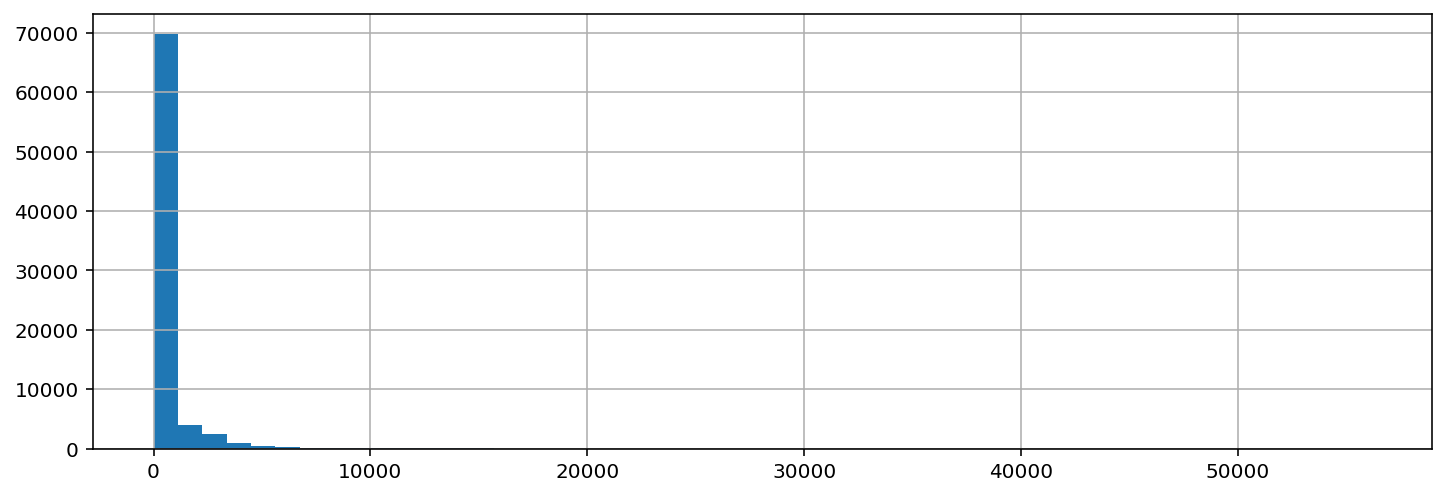

In [19]:
total_seconds.hist(bins=50, figsize=(12, 4));

### Geographical dispersion

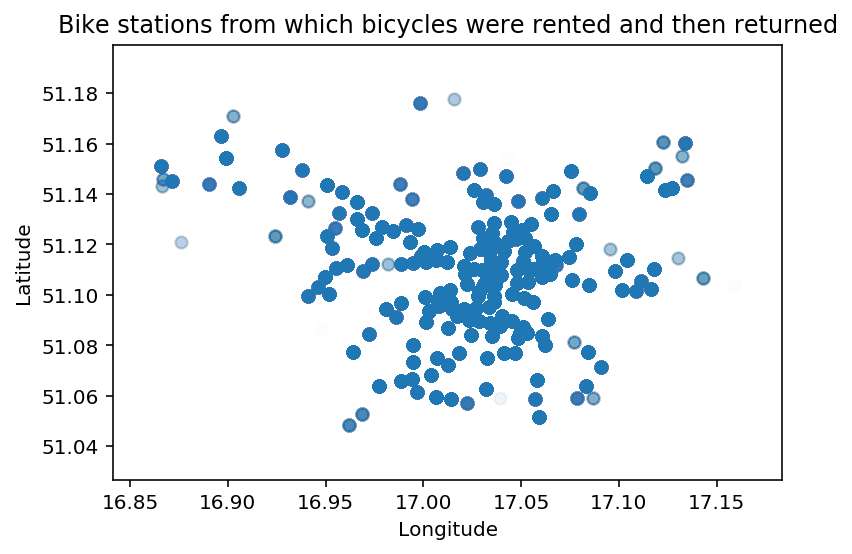

In [20]:
plt.scatter(x=bike_rentals_df.loc[idx, 'Rental station longitude'].values, 
            y=bike_rentals_df.loc[idx, 'Rental station latitude'].values, 
            alpha=0.01)
plt.title('Bike stations from which bicycles were rented and then returned')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show();

# Run full pipeline

In [21]:
# run data loading and processing pipeline
#!python run_pipeline.py --hard-delete=1